# TODO: Title
**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

    This notebook contains the steps for building the pipeline of the project.  
     First, we are going to work with the dataset, download  from the source, process, and upload it to s3 bucket, so we can use it for training the model.
     After that, here we have the instructions for training the model, and make prediction  on several images in test set.
    We can find here Hyperparameter tunning instruction, Model Profiler and Debuguing, and the deployment step for make predictions by using the generated endpoint.
 
 


**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of the TODO's and/or use more than one cell to complete all the tasks.

In [2]:
# TODO: Install any packages that you might need
!pip install smdebug

  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)


In [5]:
# TODO: Import any packages that you might need
from tqdm import tqdm
import os
from sagemaker.debugger import Rule, DebuggerHookConfig, ProfilerConfig, ProfilerRule, rule_configs, FrameworkProfile
from sagemaker import get_execution_role
from sagemaker.pytorch import PyTorch


## Data Preparation
**TODO:** Run the cell below to download the data.

The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [8]:
import os
import json
import boto3

def download_and_arrange_data():
    s3_client = boto3.client('s3')

    with open('file_list.json', 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join('train_data', k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))

download_and_arrange_data()

  0%|          | 0/1228 [00:00<?, ?it/s]

  0%|          | 1/2299 [00:00<05:52,  6.52it/s]

  0%|          | 1/2666 [00:00<05:38,  7.87it/s]

  0%|          | 2/2373 [00:00<03:41, 10.71it/s]

  0%|          | 2/1875 [00:00<02:13, 14.08it/s]

100%|██████████| 1875/1875 [03:05<00:00, 10.12it/s]


## Dataset
**TODO:** Explain what dataset you are using for this project. Give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understanding of it. You can find more information about the data [here](https://registry.opendata.aws/amazon-bin-imagery/).

In [2]:
#TODO: Perform any data cleaning or data preprocessing
from os import path, listdir, makedirs
import glob
from tqdm import tqdm

    
def train_test_split(dataset_path, per_test, per_val):
    classes_directory = listdir(dataset_path)
    result_classes_split = {'train':{ class_dir: [] for class_dir in classes_directory},
                                            'val':{ class_dir: [] for class_dir in classes_directory},
                                           'test':{ class_dir: [] for class_dir in classes_directory}}
    if per_test + per_val >= 100:
        raise Exception( 'ERROR')
    
    for class_directory in classes_directory:
        elements_class =  glob.glob(f'{path.join(dataset_path, class_directory)}/*')
        n_elements_class = len(elements_class)
        n_sample_test  =  (n_elements_class * per_test) //100
        n_sample_val  =  (n_elements_class * per_val) //100
        result_classes_split['test'][class_directory] = elements_class[:n_sample_test -1 ]
        result_classes_split['val'][class_directory] = elements_class[n_sample_test - 1 : n_sample_test  + n_sample_val - 2]
        result_classes_split['train'][class_directory] = elements_class[n_sample_test  + n_sample_val - 2 : ]
        # length = len(result_classes_split['test'][class_directory] ) + len(result_classes_split['val'][class_directory])  + len(result_classes_split['train'][class_directory])
        # assert length == len(elements_class)  ,'convertion error'
        
    return result_classes_split

def write_sample_elements(dir_name, data):
    makedirs(dir_name, exist_ok= True)
    classes = list(data.keys())
    for class_name in classes:
        dir_class = path.join(dir_name, class_name)
        makedirs(dir_class, exist_ok=True)
        for file_path in tqdm(data[class_name]):
            filename_output = path.join(path.join(dir_name, class_name), file_path.split('/')[-1])
            with open(file_path, 'rb') as img_input, open(filename_output, 'wb') as img_output:
                img_output.write(img_input.read())

In [3]:
splitted_data = train_test_split('train_data/', 20, 10)
base_directory = 'BinImages'
for dataset_name  in splitted_data:
    dir_name = path.join(base_directory,  dataset_name)    
    write_sample_elements(dir_name,  splitted_data[dataset_name])

100%|██████████| 532/532 [00:08<00:00, 59.47it/s]


In [5]:
splitted_data.keys()

dict_keys(['train', 'val', 'test'])

In [7]:
%%capture
!aws s3 cp  BinImages  s3://lucialedezmacapstoneproject/BinImages/  --recursive

# import sagemaker
# bucket = "lucialedezmacapstone"
# sagemaker_session = sagemaker.Session()
# inputs = sagemaker_session.upload_data(path="train_data", bucket=bucket, key_prefix="train_data_2")

## Model Training
**TODO:** This is the part where you can train a model. The type or architecture of the model you use is not important. 

**Note:** You will need to use the `train.py` script to train your model.

In [15]:
#TODO: Declare your model training hyperparameter.
#NOTE: You do not need to do hyperparameter tuning. You can use fixed hyperparameter values
hyperparameters = {'batch-size':  64,  'lr':  0.009, 'model-arch':  'resnet50', 'model-n-classes': 5,  'epochs': 6}

In [16]:
#TODO: Create your training estimator

role = get_execution_role()

estimator = PyTorch(
    entry_point='train.py',
    base_job_name='bin-images-estimator',
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    framework_version='1.4.0',
    py_version='py3',
    hyperparameters=hyperparameters)

In [4]:
os.environ['SM_CHANNEL_TRAINING'] = 's3://lucialedezmacapstoneproject/BinImages/train'
os.environ["SM_CHANNEL_VALIDATION"] = 's3://lucialedezmacapstoneproject/BinImages/val'
os.environ["SM_CHANNEL_TEST"] = 's3://lucialedezmacapstoneproject/BinImages/test'
os.environ['SM_MODEL_DIR']='s3://lucialedezmacapstoneproject/model/'

In [17]:
# TODO: Fit your estimator

estimator.fit({'training': 's3://lucialedezmacapstoneproject/BinImages/train', 
                      'test': 's3://lucialedezmacapstoneproject/BinImages/test',
                       'validation': 's3://lucialedezmacapstoneproject/BinImages/val'})

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: bin-images-estimator-2023-04-14-22-10-48-733


2023-04-14 22:10:50 Starting - Starting the training job...
2023-04-14 22:11:06 Starting - Preparing the instances for training...
2023-04-14 22:11:48 Downloading - Downloading input data...
2023-04-14 22:12:28 Training - Downloading the training image...
2023-04-14 22:12:49 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-04-14 22:12:58,518 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-04-14 22:12:58,522 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2023-04-14 22:12:58,533 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-04-14 22:12:58,535 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-04-14 22:12:58,740 sagemaker-containers INFO     Module default_user_module_name does not provide a setup.py.

## Standout Suggestions
You do not need to perform the tasks below to finish your project. However, you can attempt these tasks to turn your project into a more advanced portfolio piece.

### Hyperparameter Tuning
**TODO:** Here you can perform hyperparameter tuning to increase the performance of your model. You are encouraged to 
- tune as many hyperparameters as you can to get the best performance from your model
- explain why you chose to tune those particular hyperparameters and the ranges.


In [14]:
#TODO: Create your hyperparameter search space
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
### I choosed to tunned the learning rate because it is step width the model learn 
### and the batch-size, cause it is the number of samples processed before the model is updated
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128]),
}
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": objective_metric_name , "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [15]:
#TODO: Create your training estimator
from sagemaker import get_execution_role
from sagemaker.pytorch import PyTorch
role = get_execution_role()
estimator = PyTorch(
                    entry_point="train.py",
                    role=role,
                    py_version="py3",
                    framework_version="1.8",
                    instance_count=1,
                    instance_type="ml.g4dn.xlarge"
                    )# TODO: Your estimator here

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [12]:
# TODO: Fit your estimator
tuner.fit({'training': 's3://lucialedezmacapstoneproject/BinImages/train', 
               'test': 's3://lucialedezmacapstoneproject/BinImages/test',
               'validation': 's3://lucialedezmacapstoneproject/BinImages/val'})

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating hyperparameter tuning job with name: pytorch-training-230416-0219


..........................................................................................................................................................................!


In [13]:
# TODO: Find the best hyperparameters

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_hyperparameters = best_estimator.hyperparameters()
best_hyperparameters 


2023-04-16 02:29:29 Starting - Preparing the instances for training
2023-04-16 02:29:29 Downloading - Downloading input data
2023-04-16 02:29:29 Training - Training image download completed. Training in progress.
2023-04-16 02:29:29 Uploading - Uploading generated training model
2023-04-16 02:29:29 Completed - Resource reused by training job: pytorch-training-230416-0219-004-e929c132


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"128"',
 'lr': '0.00254525353426351',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-04-16-02-19-14-589"',
 'sagemaker_program': '"train.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-355502557655/pytorch-training-2023-04-16-02-19-14-589/source/sourcedir.tar.gz"'}

In [9]:
hyperparameters_tuned = { 'batch-size':  128,  'lr': 0.00254525353426351, 'profiler-debug': True}

In [10]:
# role = get_execution_role()
# hyperparameters = { 'batch-size':  128,  'lr': 0.00254525353426351}
# estimator = PyTorch(
#     entry_point='train.py',
#     base_job_name='bin-images-estimator-tuned',
#     role=role,
#     instance_count=1,
#     instance_type='ml.m5.xlarge',
#     framework_version='1.4.0',
#     py_version='py3',
#     hyperparameters=hyperparameters)
# estimator.fit({'training': 's3://lucialedezmacapstoneproject/BinImages/train', 
#                'test': 's3://lucialedezmacapstoneproject/BinImages/test',
#                'validation': 's3://lucialedezmacapstoneproject/BinImages/val'})

### Model Profiling and Debugging
**TODO:** Use model debugging and profiling to better monitor and debug your model training job.

In [29]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker import get_execution_role
from sagemaker.pytorch import PyTorch

role = get_execution_role()

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    #Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]


hook_config = DebuggerHookConfig(
    hook_parameters={"include_regex": "CrossEntropyLoss_output.*",
                     "train.save_interval": "4",
                     "eval.save_interval": "2",
                     "predict.save_interval": "4"}
)
profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

In [ ]:
# TODO: Create and fit an estimator
estimator = PyTorch(
                    entry_point="train_hook.py",
                    base_job_name="smdebugger-capstone-bin-images-final",
                    role=role,
                    py_version="py3",
                    framework_version="1.8",
                    instance_count=1,
                    instance_type="ml.m5.large",
                    hyperparameters= hyperparameters_tuned ,
                    rules=rules,
                    debugger_hook_config=hook_config,
                    profiler_config=profiler_config
                    ) # TODO: Your estimator here
estimator.fit({'training': 's3://lucialedezmacapstoneproject/BinImages/train', 
                       'test': 's3://lucialedezmacapstoneproject/BinImages/test',
                       'validation': 's3://lucialedezmacapstoneproject/BinImages/val'})

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: smdebugger-capstone-bin-images-final-2023-04-16-08-05-38-104


2023-04-16 08:05:38 Starting - Starting the training job...
2023-04-16 08:06:06 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2023-04-16 08:07:07 Downloading - Downloading input data............
2023-04-16 08:09:07 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-04-16 08:09:02,645 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-04-16 08:09:02,649 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-04-16 08:09:02,662 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-04-16 08:09:02,665 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-04-16 08:09:02,862 sagem

In [18]:
# TODO: Plot a debugging output.
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals


trial = create_trial('s3://sagemaker-us-east-1-355502557655/smdebugger-capstone-bin-images-final-2023-04-16-05-11-45-341/debug-output')#estimator.latest_job_debugger_artifacts_path()) 
## we can directly wrute the s3 debugg path

trial.tensor_names()


[2023-04-16 07:20:37.484 pytorch-1-10-cpu-py38-ml-t3-medium-9c8fa3a7688fa232cbbe37185a11:38 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-355502557655/smdebugger-capstone-bin-images-final-2023-04-16-05-11-45-341/debug-output
[2023-04-16 07:20:41.999 pytorch-1-10-cpu-py38-ml-t3-medium-9c8fa3a7688fa232cbbe37185a11:38 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2023-04-16 07:20:43.018 pytorch-1-10-cpu-py38-ml-t3-medium-9c8fa3a7688fa232cbbe37185a11:38 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight']

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")
    steps_pred, vals_pred = get_data(trial, tensor_name, mode=ModeKeys.PREDICT)
    print("loaded TEST data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()
    par_t = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    par_t.set_xlabel("Steps (PREDICT)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    (p3,) = par.plot(steps_pred, vals_pred, label="pred_" + tensor_name)
    print("completed PREDICT plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())
    
    par_t.xaxis.get_label().set_color(p3.get_color())
    leg.texts[2].set_color(p3.get_color())

    plt.ylabel(tensor_name)

    plt.show()


INFO:matplotlib.font_manager:generated new fontManager


In [20]:
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)), 
      len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)),
      len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.PREDICT)))

44 14 5


loaded TRAIN data
loaded EVAL data
loaded TEST data
completed TRAIN plot
completed EVAL plot
completed PREDICT plot


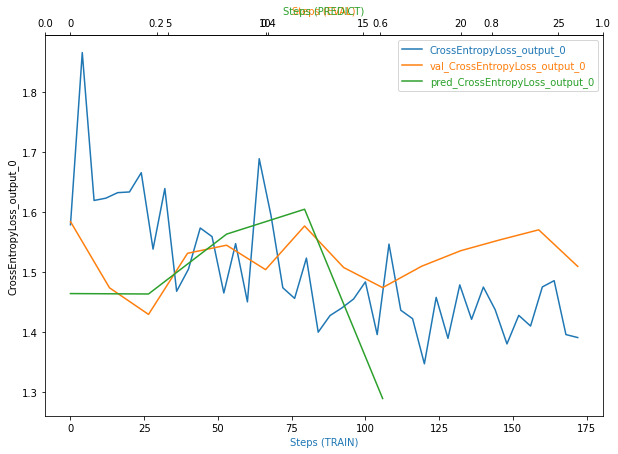

In [21]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

In [22]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-355502557655/smdebugger-capstone-bin-images-final-2023-04-16-05-11-45-341/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-355502557655/smdebugger-capstone-bin-images-final-2023-04-16-05-11-45-341/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-355502557655/smdebugger-capstone-bin-images-final-2023-04-16-05-11-45-341/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-355502557655/smdebugger-capstone-bin-images-final-2023-04-16-05-11-45-341/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-r

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [23]:
# TODO: Display the profiler output
import os
# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

### Model Deploying and Querying
**TODO:** Can you deploy your model to an endpoint and then query that endpoint to get a result?

In [24]:
# TODO: Deploy your model to an endpoint
estimator = PyTorch.attach('smdebugger-capstone-bin-images-final-2023-04-16-05-11-45-341')
predictor=estimator.deploy(initial_instance_count=1, 
    instance_type='ml.m5.large') # TODO: Add your deployment configuration like instance type and number of instances

ClientError: An error occurred (404) when calling the HeadObject operation: Not Found

In [8]:
# TODO: Run an prediction on the endpoint
from train import create_data_loaders

test_loader = create_data_loaders('BinImages/test', 4)
image_loader = None
for images,labels in test_loader:
    break 

# #use the predictor to make a prediction
inference = predictor.predict(images)


ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (0) from primary with message "Your invocation timed out while waiting for a response from container primary. Review the latency metrics for each container in Amazon CloudWatch, resolve the issue, and try again.". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/smdebugger-capstone-bin-images-2023-04-16-04-58-42-788 in account 355502557655 for more information.

In [25]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: smdebugger-capstone-bin-images-final-2023-04-16-07-22-52-241
INFO:sagemaker:Deleting endpoint with name: smdebugger-capstone-bin-images-final-2023-04-16-07-22-52-241


### Cheaper Training and Cost Analysis
**TODO:** Can you perform a cost analysis of your system and then use spot instances to lessen your model training cost?

In [ ]:
# TODO: Cost Analysis

In [ ]:
# TODO: Train your model using a spot instance

### Multi-Instance Training
**TODO:** Can you train your model on multiple instances?

In [ ]:
# TODO: Train your model on Multiple Instances

estimator = PyTorch(
                    entry_point="train.py",
                    base_job_name="bin-images-multiinstance-capstone",
                    role=role,
                    py_version="py3",
                    framework_version="1.8",
                    instance_count=5,
                    instance_type="ml.m5.large",
                    hyperparameters=best_hyperparameters ,
                    rules=rules,
                    debugger_hook_config=hook_config,
                    profiler_config=profiler_config
                    ) # TODO: Your estimator here
estimator.fit({'training': 's3://lucialedezmacapstoneproject/BinImages/train', 
                       'test': 's3://lucialedezmacapstoneproject/BinImages/test',
                       'validation': 's3://lucialedezmacapstoneproject/BinImages/val'})
